In [102]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import talib as ta

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [103]:

# 1. 读取数据
df = pd.read_csv('data/spot/binance/15m/BTC_USDT.csv')

# 选择时间范围
START_DATE = '2024-06-01'
END_DATE = '2025-06-30'
# 确保时间列为datetime类型
df['datetime'] = pd.to_datetime(df['datetime'])
data = df[(df['datetime'] >= START_DATE) & (df['datetime'] <= END_DATE)]

data['ret'] = data['close'].pct_change()

C:\Users\hp\AppData\Local\Temp\ipykernel_43488\239542440.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ret'] = data['close'].pct_change()


In [104]:
data

,datetime,open,high,low,close,volume,ret
119674,2024-06-01 00:00:00,67540.01,67703.89,67540.00,67586.61,274.50877,NaN
119675,2024-06-01 00:15:00,67586.61,67586.61,67507.39,67559.73,82.60933,-0.000398
119676,2024-06-01 00:30:00,67559.73,67636.28,67552.00,67603.06,139.32988,0.000641
119677,2024-06-01 00:45:00,67603.06,67689.64,67603.05,67655.66,73.42276,0.000778
119678,2024-06-01 01:00:00,67655.66,67710.29,67600.00,67621.56,126.42777,-0.000504
...,...,...,...,...,...,...,...
157494,2025-06-29 23:00:00,108079.91,108261.66,108013.28,108054.26,102.69338,-0.000237
157495,2025-06-29 23:15:00,108054.25,108426.00,108024.12,108388.99,190.22441,0.003098
157496,2025-06-29 23:30:00,108388.99,108436.47,108300.00,108300.01,133.57727,-0.000821
157497,2025-06-29 23:45:00,108300.00,108415.51,108300.00,108356.93,87.40906,0.000526


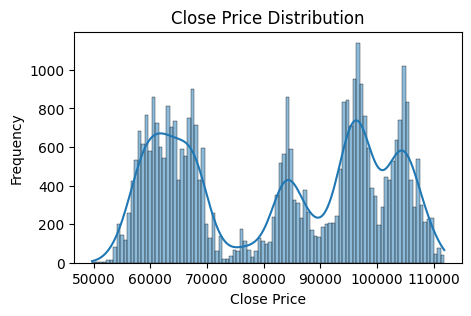

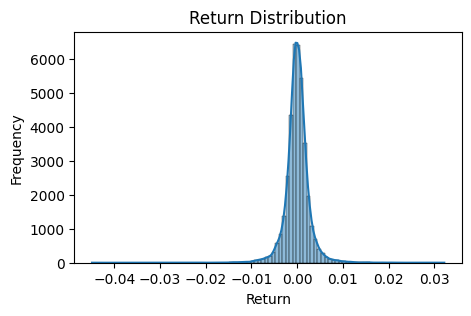

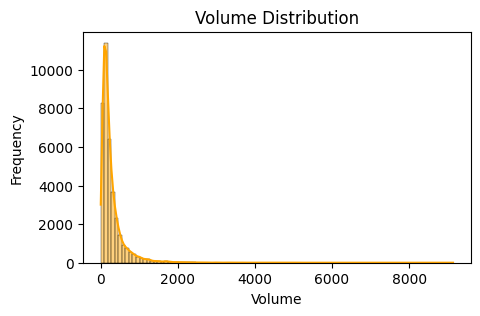

                open           high            low          close  \
count   37825.000000   37825.000000   37825.000000   37825.000000   
mean    82564.430283   82702.440082   82424.311277   82565.509939   
std     17468.890550   17490.933394   17446.614348   17469.228217   
min     49732.560000   50273.730000   49000.000000   49732.570000   
25%     64690.890000   64815.630000   64571.910000   64690.890000   
50%     84647.300000   84788.010000   84524.140000   84647.320000   
75%     97700.150000   97843.110000   97546.680000   97700.590000   
max    111898.740000  111980.000000  111681.810000  111898.740000   

             volume  
count  37825.000000  
mean     286.654208  
std      361.891419  
min        3.985380  
25%      103.272040  
50%      178.498680  
75%      330.183650  
max     9136.883710  


,datetime,open,high,low,close,volume,ret
count,37825,37825.000000,37825.000000,37825.000000,37825.000000,37825.000000,3.782400e+04
mean,2024-12-15 00:00:00,82564.430283,82702.440082,82424.311277,82565.509939,286.654208,1.607124e-05
min,2024-06-01 00:00:00,49732.560000,50273.730000,49000.000000,49732.570000,3.985380,-4.485113e-02
25%,2024-09-07 12:00:00,64690.890000,64815.630000,64571.910000,64690.890000,103.272040,-1.167303e-03
50%,2024-12-15 00:00:00,84647.300000,84788.010000,84524.140000,84647.320000,178.498680,9.748751e-07
75%,2025-03-23 12:00:00,97700.150000,97843.110000,97546.680000,97700.590000,330.183650,1.221334e-03
max,2025-06-30 00:00:00,111898.740000,111980.000000,111681.810000,111898.740000,9136.883710,3.216082e-02
std,NaN,17468.890550,17490.933394,17446.614348,17469.228217,361.891419,2.672207e-03


In [105]:

# 2. 数据预处理，做一些初步的数据统计分布描述

# 绘制价格分布直方图
plt.figure(figsize=(5, 3))
sns.histplot(data['close'], bins=100, kde=True)
plt.title('Close Price Distribution')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.show()

# 绘制收益率分布直方图
plt.figure(figsize=(5, 3))
sns.histplot(data['ret'], bins=100, kde=True)
plt.title('Return Distribution')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.show()

# 绘制成交量分布直方图
plt.figure(figsize=(5, 3))
sns.histplot(data['volume'], bins=100, kde=True, color='orange')
plt.title('Volume Distribution')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.show()

# 计算并显示主要数值特征的描述性统计
print(data[['open', 'high', 'low', 'close', 'volume']].describe())
data.describe()


In [106]:

# # 2. 特征工程（示例：用常见技术指标）
# """
# 技术指标列表
# 趋势: EMA (20, 60, 100, 200), MACD (12,26,9; 5,35,5), ADX (14)
# 动量: RSI (10, 20, 60), %K Stochastic (10, 30, 200)
# 反转: ROC(RSI) (10, 20, 50)
# 振幅: ATR (20, 60, 100), Bollinger Bands (20, 2)
# 成交量: OBV, VWAP
# 短期动态: MOM (10, 30, 50), PROC (10, 50)
# """

# # 用talib计算特征，全部用talib函数

# # 用talib计算特征，全部用talib函数
# data['ema_20'] = ta.EMA(data['close'], timeperiod=20)
# data['ema_60'] = ta.EMA(data['close'], timeperiod=60)
# data['ema_100'] = ta.EMA(data['close'], timeperiod=100)
# data['ema_200'] = ta.EMA(data['close'], timeperiod=200)

# macd_20_60, macdsignal_20_60, macdhist_20_60 = ta.MACD(data['close'], fastperiod=20, slowperiod=60, signalperiod=9)
# macd_10_20, macdsignal_10_20, macdhist_10_20 = ta.MACD(data['close'], fastperiod=10, slowperiod=20, signalperiod=5)
# data['macd_20_60'] = macd_20_60
# data['macd_10_20'] = macd_10_20

# data['adx_10'] = ta.ADX(data['high'], data['low'], data['close'], timeperiod=10)
# data['adx_20'] = ta.ADX(data['high'], data['low'], data['close'], timeperiod=20)
# data['adx_60'] = ta.ADX(data['high'], data['low'], data['close'], timeperiod=60)

# data['rsi_7'] = ta.RSI(data['close'], timeperiod=7)
# data['rsi_20'] = ta.RSI(data['close'], timeperiod=20)
# data['rsi_60'] = ta.RSI(data['close'], timeperiod=60)

# slowk_10, slowd_10 = ta.STOCH(data['high'], data['low'], data['close'], fastk_period=10, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
# slowk_30, slowd_30 = ta.STOCH(data['high'], data['low'], data['close'], fastk_period=30, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
# slowk_100, slowd_100 = ta.STOCH(data['high'], data['low'], data['close'], fastk_period=100, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
# data['stoch_k_10'] = slowk_10
# data['stoch_k_30'] = slowk_30
# data['stoch_k_100'] = slowk_100

# data['roc_rsi_10'] = ta.ROC(data['rsi_7'], timeperiod=10)
# data['roc_rsi_20'] = ta.ROC(data['rsi_7'], timeperiod=20)
# data['roc_rsi_50'] = ta.ROC(data['rsi_7'], timeperiod=50)

# data['atr_20'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=20)
# data['atr_60'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=60)
# data['atr_100'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=100)

# # talib没有直接的Bollinger带宽和百分比，需手动计算
# upper, middle, lower = ta.BBANDS(data['close'], timeperiod=30, nbdevup=2, nbdevdn=2, matype=0)
# data['bb_width'] = upper - lower
# data['bb_percent'] = (data['close'] - lower) / (upper - lower)

# data['obv'] = ta.OBV(data['close'], data['volume'])

# # VWAP简单实现
# data['vwap'] = (data['volume'] * (data['high'] + data['low'] + data['close']) / 3).cumsum() / data['volume'].cumsum()

# data['mom_5'] = ta.MOM(data['close'], timeperiod=5)
# data['mom_20'] = ta.MOM(data['close'], timeperiod=20)
# data['mom_50'] = ta.MOM(data['close'], timeperiod=50)

# data['proc_5'] = ta.ROC(data['close'], timeperiod=5)
# data['proc_20'] = ta.ROC(data['close'], timeperiod=20)

# data['vol_ma_20'] = data['volume'].rolling(window=20).mean()
# data['vol_ma_60'] = data['volume'].rolling(window=60).mean()

In [107]:

# 2. 特征工程（示例：用常见技术指标）
"""
技术指标列表
趋势: EMA (20, 60, 100, 200), MACD (12,26,9; 5,35,5), ADX (14)
动量: RSI (10, 20, 60), %K Stochastic (10, 30, 200)
反转: ROC(RSI) (10, 20, 50)
振幅: ATR (20, 60, 100), Bollinger Bands (20, 2)
成交量: OBV, VWAP
短期动态: MOM (10, 30, 50), PROC (10, 50)
"""

# 用talib计算特征，全部用talib函数

# 用talib计算特征，全部用talib函数
# data['ema_20'] = ta.EMA(data['close'], timeperiod=20)
# data['ema_100'] = ta.EMA(data['close'], timeperiod=100)

# macd_20_60, macdsignal_20_60, macdhist_20_60 = ta.MACD(data['close'], fastperiod=20, slowperiod=60, signalperiod=9)
# macd_10_20, macdsignal_10_20, macdhist_10_20 = ta.MACD(data['close'], fastperiod=10, slowperiod=20, signalperiod=5)
# data['macd_10_20'] = macd_10_20

# data['adx_10'] = ta.ADX(data['high'], data['low'], data['close'], timeperiod=10)



# data['rsi_20'] = ta.RSI(data['close'], timeperiod=20)


# slowk_10, slowd_10 = ta.STOCH(data['high'], data['low'], data['close'], fastk_period=10, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
# slowk_30, slowd_30 = ta.STOCH(data['high'], data['low'], data['close'], fastk_period=30, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
# slowk_100, slowd_100 = ta.STOCH(data['high'], data['low'], data['close'], fastk_period=100, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
# data['stoch_k_10'] = slowk_10
# data['stoch_k_30'] = slowk_30
# data['stoch_k_100'] = slowk_100


# data['atr_20'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=20)
# data['atr_60'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=60)
# data['atr_100'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=100)

# # talib没有直接的Bollinger带宽和百分比，需手动计算
# upper, middle, lower = ta.BBANDS(data['close'], timeperiod=30, nbdevup=2, nbdevdn=2, matype=0)
# data['bb_width'] = upper - lower
# data['bb_percent'] = (data['close'] - lower) / (upper - lower)

# data['obv'] = ta.OBV(data['close'], data['volume'])

# # VWAP简单实现
# data['vwap'] = (data['volume'] * (data['high'] + data['low'] + data['close']) / 3).cumsum() / data['volume'].cumsum()

# data['mom_20'] = ta.MOM(data['close'], timeperiod=20)
# data['proc_20'] = ta.ROC(data['close'], timeperiod=20)

# data['vol_ma_20'] = data['volume'].rolling(window=20).mean()

'\n技术指标列表\n趋势: EMA (20, 60, 100, 200), MACD (12,26,9; 5,35,5), ADX (14)\n动量: RSI (10, 20, 60), %K Stochastic (10, 30, 200)\n反转: ROC(RSI) (10, 20, 50)\n振幅: ATR (20, 60, 100), Bollinger Bands (20, 2)\n成交量: OBV, VWAP\n短期动态: MOM (10, 30, 50), PROC (10, 50)\n'

In [108]:
data['ema_20'] = data['close'] / ta.EMA(data['close'], timeperiod=20)
data['ema_100'] = data['close'] / ta.EMA(data['close'], timeperiod=100)

data['rsi_20'] = ta.RSI(data['close'], timeperiod=14) / 100

slowk_10, slowd_10 = ta.STOCH(data['high'], data['low'], data['close'], fastk_period=10, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
data['stoch_k_10'] = slowk_10

data['atr_20'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=20) / data['close']

upper, middle, lower = ta.BBANDS(data['close'], timeperiod=30, nbdevup=2, nbdevdn=2, matype=0)
data['bb_width'] = upper - lower
data['bb_percent'] = (data['close'] - lower) / (upper - lower)

data['adx_10'] = ta.ADX(data['high'], data['low'], data['close'], timeperiod=10) / 100

data['obv'] = ta.OBV(data['close'], data['volume']) / (data['volume'].rolling(window=20).mean())
data['vol_ma_20'] = data['volume'] / data['volume'].rolling(window=20).mean()

C:\Users\hp\AppData\Local\Temp\ipykernel_43488\1272955856.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ema_20'] = data['close'] / ta.EMA(data['close'], timeperiod=20)
C:\Users\hp\AppData\Local\Temp\ipykernel_43488\1272955856.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ema_100'] = data['close'] / ta.EMA(data['close'], timeperiod=100)
C:\Users\hp\AppData\Local\Temp\ipykernel_43488\1272955856.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

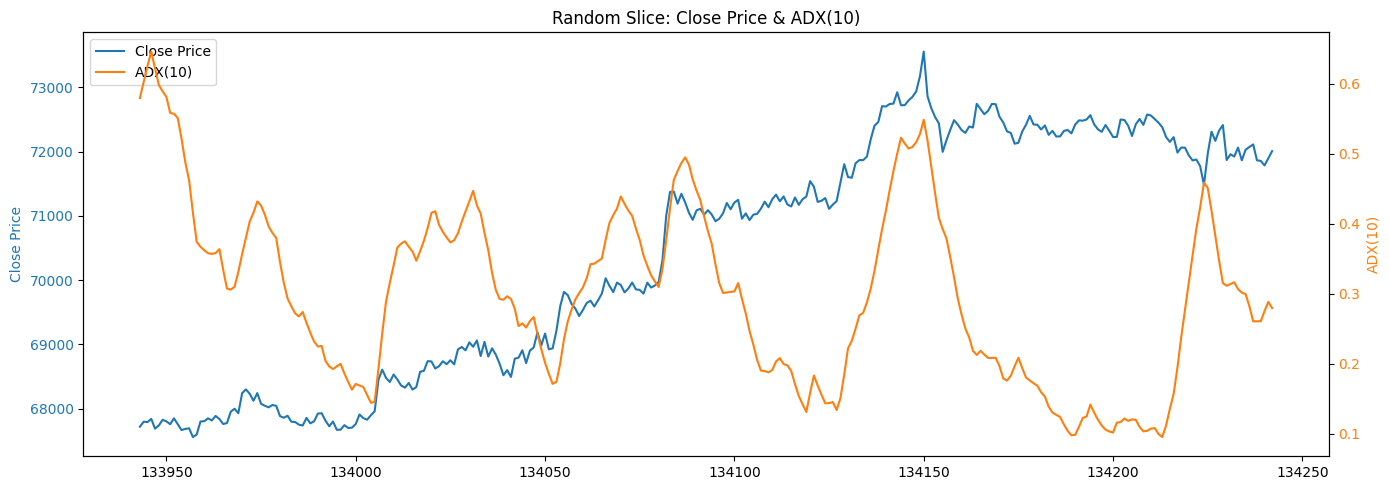

In [109]:
# 随机选取一段连续切片，画ADX和Close Price

N = 300  # 片段长度，可调整
if 'adx_10' not in data.columns:
    data['adx_10'] = ta.ADX(data['high'], data['low'], data['close'], timeperiod=10) / 100

data = data.dropna(subset=['adx_10', 'close'])
start = np.random.randint(0, len(data) - N + 1)
slice_data = data.iloc[start:start+N]

plt.figure(figsize=(14, 5))
ax1 = plt.gca()
ax2 = ax1.twinx()
line_close, = ax1.plot(slice_data.index, slice_data['close'], color='tab:blue', label='Close Price')
ax1.set_ylabel('Close Price', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

line_adx, = ax2.plot(slice_data.index, slice_data['adx_10'], color='tab:orange', label='ADX(10)')
ax2.set_ylabel('ADX(10)', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

lines = [line_close, line_adx]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')
plt.title('Random Slice: Close Price & ADX(10)')
plt.tight_layout()
plt.show()

In [110]:
TARGET_PERIOD = 2
# T-1 到 T+4 的涨跌为目标
# >0 为正样本，<=0为负样本，符合lightgbm的二分类标记
data['target'] = (data['close'].shift(-TARGET_PERIOD) - data['close'] > 0).astype(int)

# # 删除含有NaN值的行
# data.dropna(inplace=True)  

C:\Users\hp\AppData\Local\Temp\ipykernel_43488\2284811210.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = (data['close'].shift(-TARGET_PERIOD) - data['close'] > 0).astype(int)


In [111]:
# # T-1 到 T+4 的涨跌为目标
# # >0 为正样本，<=0为负样本，符合lightgbm的二分类标记
# target_ret = (data['close'].shift(-TARGET_PERIOD) / data['close']) - 1
# data['target'] = 1
# data.loc[target_ret > 0.0015, 'target'] = 2
# data.loc[target_ret < -0.001, 'target'] = 0
# data.loc[data['adx_10'] < 0.25, 'target'] = 1  # 剔除adx < 25，因为ADX过低表示趋势不明显，模型难以学习

# # 删除含有NaN值的行
# data.dropna(inplace=True)  

In [112]:
# 剔除adx < 25，因为ADX过低表示趋势不明显，模型难以学习
# data = data[data['adx_10'] > 0.25]

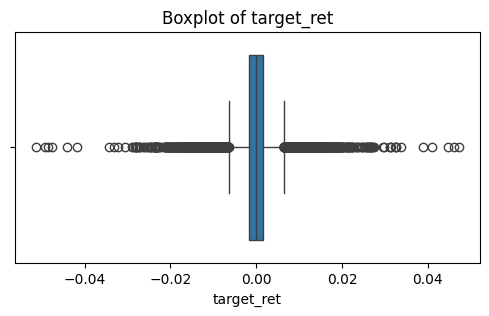

0.00   -0.051329
0.01   -0.010850
0.05   -0.005306
0.10   -0.003574
0.25   -0.001588
0.50    0.000040
0.75    0.001653
0.90    0.003646
0.95    0.005425
0.99    0.011105
1.00    0.047218
Name: close, dtype: float64


In [113]:
# 绘制 target_ret 的箱线图
plt.figure(figsize=(6, 3))
sns.boxplot(x=target_ret)
plt.title('Boxplot of target_ret')
plt.xlabel('target_ret')
plt.show()

# 查看 target_ret 的分位数分布
print(target_ret.quantile([0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1]))

In [114]:
print(data['target'].value_counts(normalize=True))

target
1    0.50656
0    0.49344
Name: proportion, dtype: float64


In [115]:
# 划分特征和目标
feature_cols = [col for col in data.columns if col not in ['datetime', 'target']]
X = data[feature_cols]
y = data['target']

# 只划分训练集和验证集（不再有 test）
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=False)

# 标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [116]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([15868, 16267], dtype=int64))

In [117]:
lgb_train = lgb.Dataset(X_train_scaled, y_train)
lgb_val = lgb.Dataset(X_val_scaled, y_val)

params = {
    'num_leaves': 40,  # Increase the number of leaves to allow the model to capture more complex patterns
    'min_data_in_leaf': 30,  # Reduce the minimum data in a leaf to allow smaller leaves
    'objective': 'binary',  # Correct the objective to 'binary' for binary classification
    'num_class': 1,  # Set to 1 for binary classification
    'max_depth': -1,
    'learning_rate': 0.01,
    "min_sum_hessian_in_leaf": 5,  # Slightly reduce the minimum sum of hessian in a leaf
    "boosting": "gbdt",
    "feature_fraction": 0.95,  # Increase feature fraction to use more features
    "bagging_freq": 1,
    "bagging_fraction": 0.8,  # Increase bagging fraction to use more data in each iteration
    "bagging_seed": 11,
    # "lambda_l1": 0.05,  # Reduce L1 regularization to allow more flexibility
    "verbosity": -1,
    "nthread": 4,
    'metric': 'binary_logloss',  # Use binary_logloss for binary classification
    "random_state": 2019,
    'device': 'gpu',
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=300,
    valid_sets=[lgb_train, lgb_val],
)

In [118]:
# from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# # 阈值设为0.5，转为二分类标签
# y_pred_test_cls = (y_pred_test > 0.5).astype(int)
# y_train_pred = gbm.predict(X_train_scaled)
# y_train_pred_cls = (y_train_pred > 0.5).astype(int)
# y_val_pred = gbm.predict(X_val_scaled)
# y_val_pred_cls = (y_val_pred > 0.5).astype(int)

# # 1. 分类报告
# print("Test Classification Report:")
# print(classification_report(y_test, y_pred_test_cls))

# # 2. 混淆矩阵
# cm = confusion_matrix(y_test, y_pred_test_cls)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap='Blues')
# plt.title("Test Confusion Matrix")
# plt.show()

# # 3. ROC曲线
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
# roc_auc = auc(fpr, tpr)
# plt.figure(figsize=(5,4))
# plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
# plt.plot([0,1], [0,1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Test ROC Curve')
# plt.legend()
# plt.show()

# # 4. 预测概率分布
# plt.figure(figsize=(6,3))
# sns.histplot(y_pred_test, bins=50, kde=True, color='orange', label='Predicted Prob')
# sns.histplot(y_test, bins=2, color='blue', label='True Label', alpha=0.5, stat='density')
# plt.legend()
# plt.title('Test Set: Predicted Probability Distribution')
# plt.show()


C:\Users\hp\AppData\Local\Temp\ipykernel_43488\3881638292.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')


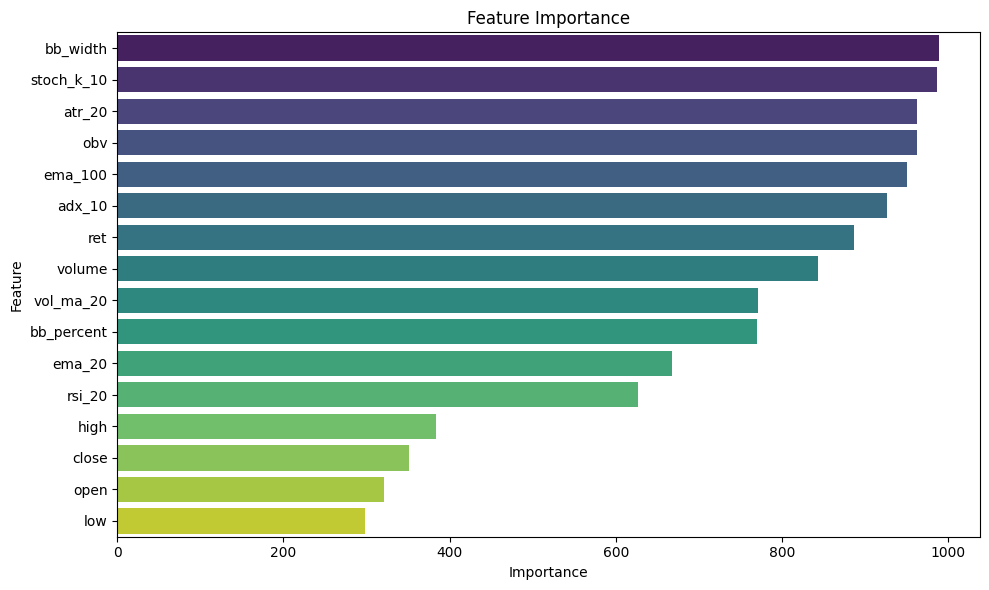

In [119]:

# Get feature importance
importance = gbm.feature_importance(importance_type='split')
feature_importance = pd.DataFrame({'Feature': feature_cols, 'Importance': importance})

# Sort by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Train Classification Report:
              precision    recall  f1-score   support

           0     0.7071    0.5543    0.6214     15868
           1     0.6409    0.7760    0.7020     16267

    accuracy                         0.6665     32135
   macro avg     0.6740    0.6651    0.6617     32135
weighted avg     0.6736    0.6665    0.6622     32135

Validation Classification Report:
              precision    recall  f1-score   support

           0     0.5042    0.6276    0.5591      2787
           1     0.5286    0.4036    0.4577      2884

    accuracy                         0.5137      5671
   macro avg     0.5164    0.5156    0.5084      5671
weighted avg     0.5166    0.5137    0.5076      5671



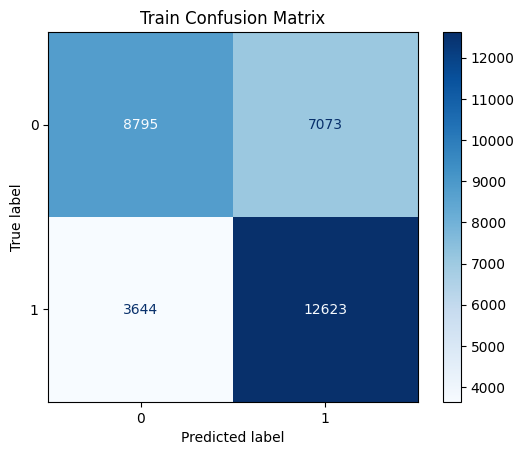

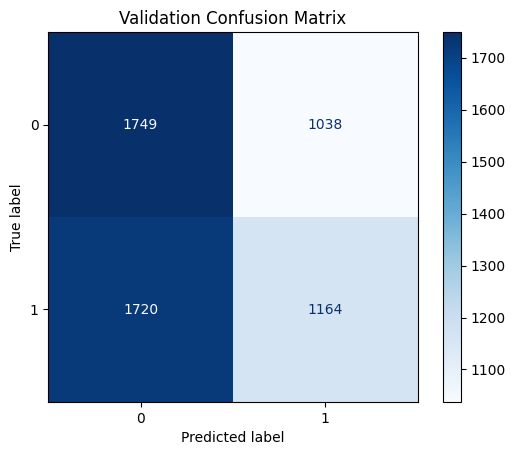

In [120]:

# 预测与评价
y_train_pred = gbm.predict(X_train_scaled)
y_val_pred = gbm.predict(X_val_scaled)
y_train_cls = (y_train_pred > 0.5).astype(int)
y_val_cls = (y_val_pred > 0.5).astype(int)

print("Train Classification Report:")
print(classification_report(y_train, y_train_cls, digits=4))
print("Validation Classification Report:")
print(classification_report(y_val, y_val_cls, digits=4))

cm_train = confusion_matrix(y_train, y_train_cls)
cm_val = confusion_matrix(y_val, y_val_cls)
ConfusionMatrixDisplay(cm_train).plot(cmap='Blues')
plt.title("Train Confusion Matrix")
plt.show()
ConfusionMatrixDisplay(cm_val).plot(cmap='Blues')
plt.title("Validation Confusion Matrix")
plt.show()


In [121]:
threshold_high = 0.54
threshold_low = 0.46

y_train_cls = pd.Series(0, index=y_train.index)
y_train_cls[y_train_pred > threshold_high] = 1
y_train_cls[y_train_pred < threshold_low] = -1

y_val_cls = pd.Series(0, index=y_val.index)
y_val_cls[y_val_pred > threshold_high] = 1
y_val_cls[y_val_pred < threshold_low] = -1

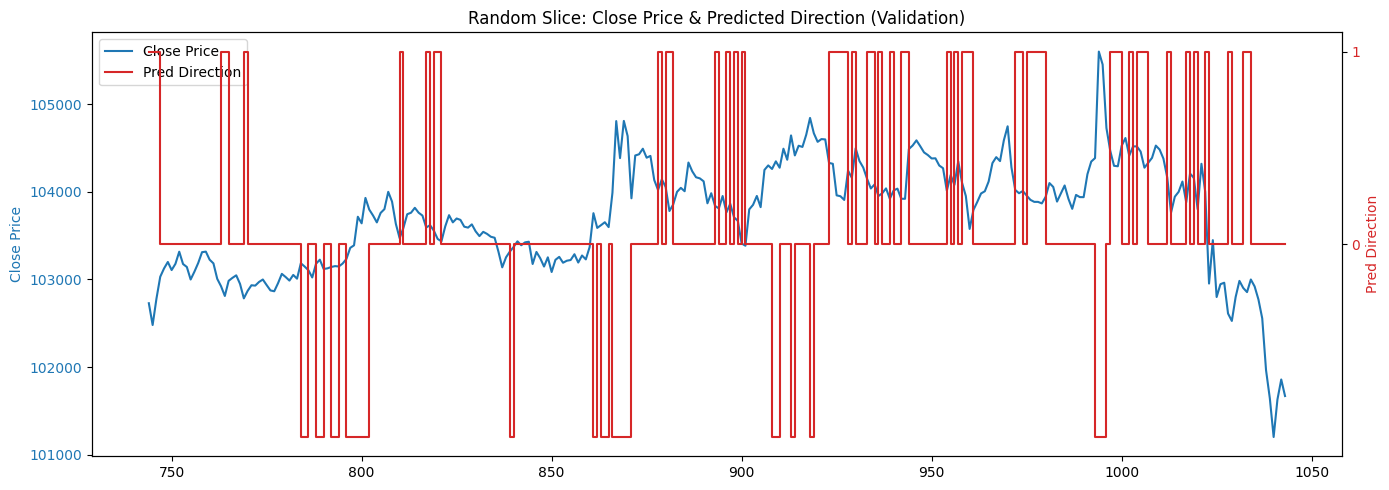

In [122]:
# 随机切片画pred方向和价格（修正版，索引对齐）
N = 300
close_val = X_val['close'].reset_index(drop=True)
if 'datetime' in X_val.columns:
    datetime_val = X_val['datetime'].reset_index(drop=True)
else:
    datetime_val = close_val.index

y_val_cls = pd.Series(y_val_cls).reset_index(drop=True)

start = np.random.randint(0, len(y_val_cls) - N + 1)
slice_idx = slice(start, start + N)

plt.figure(figsize=(14, 5))
ax1 = plt.gca()
ax2 = ax1.twinx()
line_price, = ax1.plot(datetime_val[slice_idx], close_val[slice_idx], color='tab:blue', label='Close Price')
ax1.set_ylabel('Close Price', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
line_pred, = ax2.plot(datetime_val[slice_idx], y_val_cls[slice_idx], color='tab:red', label='Pred Direction', drawstyle='steps-post')
ax2.set_ylabel('Pred Direction', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_yticks([0, 1])
lines = [line_price, line_pred]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')
plt.title('Random Slice: Close Price & Predicted Direction (Validation)')
plt.tight_layout()
plt.show()

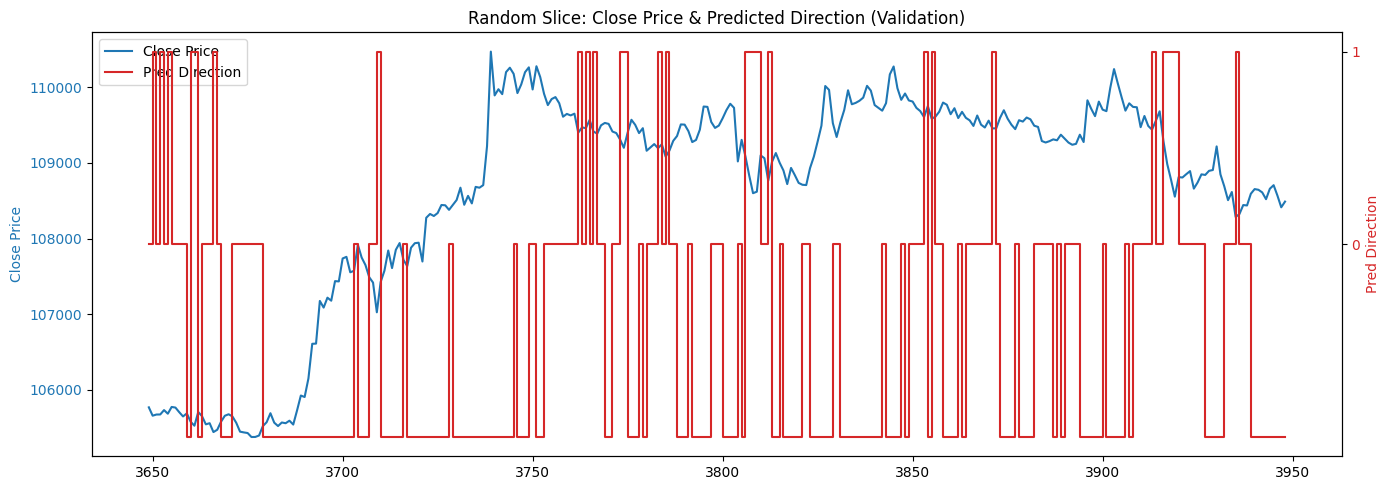

In [123]:
# 随机切片画pred方向和价格
N = 300
# 保证索引对齐
close_val = X_val['close'].reset_index(drop=True)
if 'datetime' in X_val.columns:
    datetime_val = X_val['datetime'].reset_index(drop=True)
else:
    datetime_val = close_val.index

y_val_cls = pd.Series(y_val_cls).reset_index(drop=True)

start = np.random.randint(0, len(y_val_cls) - N + 1)
slice_idx = slice(start, start + N)

plt.figure(figsize=(14, 5))
ax1 = plt.gca()
ax2 = ax1.twinx()
line_price, = ax1.plot(datetime_val[slice_idx], close_val[slice_idx], color='tab:blue', label='Close Price')
ax1.set_ylabel('Close Price', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
line_pred, = ax2.plot(datetime_val[slice_idx], y_val_cls[slice_idx], color='tab:red', label='Pred Direction', drawstyle='steps-post')
ax2.set_ylabel('Pred Direction', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_yticks([0, 1])
lines = [line_price, line_pred]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')
plt.title('Random Slice: Close Price & Predicted Direction (Validation)')
plt.tight_layout()
plt.show()

In [124]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 多分类预测
y_train_pred = gbm.predict(X_train_scaled)
y_val_pred = gbm.predict(X_val_scaled)
y_train_pred_cls = np.argmax(y_train_pred, axis=1)
y_val_pred_cls = np.argmax(y_val_pred, axis=1)

# 分类报告
print("Train Classification Report:")
print(classification_report(y_train, y_train_pred_cls, digits=4))
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred_cls, digits=4))

# 混淆矩阵
cm = confusion_matrix(y_train, y_train_pred_cls)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Train Confusion Matrix (3-class)")
plt.show()

cm = confusion_matrix(y_val, y_val_pred_cls)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Validation Confusion Matrix (3-class)")
plt.show()

# 预测概率分布（val）
plt.figure(figsize=(6,3))
sns.histplot(np.max(y_val_pred, axis=1), bins=50, kde=True, color='orange', label='Predicted Max Prob')
sns.histplot(y_val, bins=3, color='blue', label='True Label', alpha=0.5, stat='density')
plt.legend()
plt.title('Validation Set: Predicted Probability Distribution')
plt.show()

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
aligned_close_train = data.loc[y_train.index, 'close'].shift(-TARGET_PERIOD)
aligned_datetime_train = data.loc[y_train.index, 'datetime'].shift(-TARGET_PERIOD)

# 去掉由于 shift 产生的 NaN 尾部，并随机选择一个连续片段长度 N_train
N_train = 300
mask_train = aligned_close_train.notna().to_numpy()
aligned_close_train = aligned_close_train[mask_train]
aligned_datetime_train = aligned_datetime_train[mask_train]
y_train_pred_cls_aligned = y_train_pred_cls[mask_train]

M_train = len(aligned_close_train)
if M_train == 0:
    raise ValueError("没有可用的训练样本（全为 NaN）。")
N_train = min(N_train, M_train)
# 可固定随机种子以复现：np.random.seed(42)
start = np.random.randint(0, M_train - N_train + 1)
aligned_close_train = aligned_close_train.iloc[start:start + N_train]
aligned_datetime_train = aligned_datetime_train.iloc[start:start + N_train]
y_train_pred_cls_aligned = y_train_pred_cls_aligned[start:start + N_train]

plt.figure(figsize=(14, 5))
ax1 = plt.gca()
ax2 = ax1.twinx()
line_price, = ax1.plot(aligned_datetime_train, aligned_close_train, color='tab:blue', label='Close (future aligned)', linewidth=1.5)
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Close Price', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
line_cls, = ax2.plot(aligned_datetime_train, y_train_pred_cls_aligned, color='tab:red',
                     label='Predicted Class', linewidth=1.5, drawstyle='steps-post')
ax2.set_ylabel('Predicted Class', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_yticks([0, 1, 2])
ax2.set_ylim(-0.5, 2.5)
lines = [line_price, line_cls]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')
plt.title('Future-aligned Close vs Predicted Class (Train Set)')
plt.tight_layout()
plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 32067 but corresponding boolean dimension is 18902

In [ ]:
aligned_close_val = data.loc[y_val.index, 'close'].shift(-TARGET_PERIOD)
aligned_datetime_val = data.loc[y_val.index, 'datetime'].shift(-TARGET_PERIOD)

N = 500
mask = aligned_close_val.notna().to_numpy()
aligned_close_val = aligned_close_val[mask]
aligned_datetime_val = aligned_datetime_val[mask]
y_val_pred_cls_aligned = y_val_pred_cls[mask]

M = len(aligned_close_val)
if M == 0:
    raise ValueError("没有可用的验证样本（全为 NaN）。")
N = min(N, M)
start = np.random.randint(0, M - N + 1)
aligned_close_val = aligned_close_val.iloc[start:start + N]
aligned_datetime_val = aligned_datetime_val.iloc[start:start + N]
y_val_pred_cls_aligned = y_val_pred_cls_aligned[start:start + N]

plt.figure(figsize=(14, 5))
ax1 = plt.gca()
ax2 = ax1.twinx()
line_price, = ax1.plot(aligned_datetime_val, aligned_close_val, color='tab:blue',
                       label='Close (future aligned)', linewidth=1.5)
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Close Price', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

line_cls, = ax2.plot(aligned_datetime_val, y_val_pred_cls_aligned, color='tab:red',
                     label='Predicted Class', linewidth=1.5, drawstyle='steps-post')
ax2.set_ylabel('Predicted Class', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_yticks([0, 1, 2])
ax2.set_ylim(-0.5, 2.5)

lines = [line_price, line_cls]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')
plt.title('Future-aligned Close vs Predicted Class (Validation Set)')
plt.tight_layout()
plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 5659 but corresponding boolean dimension is 3336